In [1]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import re

In [2]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

# Read data from file 

In [3]:
def get_file_data(stop_word_removal='no'):
    file_contents = []
    with open('data/DL.txt') as f:
        file_contents = f.read()
    
    text = []
    #print(file_contents)
    for val in file_contents.split('.'):
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
        
    return text

In [4]:
text=get_file_data()

UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 2755: character maps to <undefined>

# Generate variables 

    word_to_index : A dictionary mapping each word to an integer value {'modern': 0, 'humans': 1}

    index_to_word : A dictionary mapping each word to an integer value {0: 'modern', 1: 'humans'}

    corpus  : The entire data consisting of all the words

    vocab_size : Number of unique words in the corpus

In [7]:
def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

Example: 

In [9]:
text=["Deep learning AI is able to learn without human supervision", 
       "Deep learning form of machine learning can be used to help detect fraud"]
#text = ['Artificial neural networks were inspired by information processing and distributed communication nodes in biological systems']
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
print('Number of unique words:' , vocab_size)
print('word_to_index : ',word_to_index)
print('index_to_word : ',index_to_word)
print('corpus:',corpus)
print('Length of corpus :',length_of_corpus)

Number of unique words: 19
word_to_index :  {'deep': 0, 'learning': 1, 'ai': 2, 'is': 3, 'able': 4, 'to': 5, 'learn': 6, 'without': 7, 'human': 8, 'supervision': 9, 'form': 10, 'of': 11, 'machine': 12, 'can': 13, 'be': 14, 'used': 15, 'help': 16, 'detect': 17, 'fraud': 18}
index_to_word :  {0: 'deep', 1: 'learning', 2: 'ai', 3: 'is', 4: 'able', 5: 'to', 6: 'learn', 7: 'without', 8: 'human', 9: 'supervision', 10: 'form', 11: 'of', 12: 'machine', 13: 'can', 14: 'be', 15: 'used', 16: 'help', 17: 'detect', 18: 'fraud'}
corpus: ['deep', 'learning', 'ai', 'is', 'able', 'to', 'learn', 'without', 'human', 'supervision', 'deep', 'learning', 'form', 'of', 'machine', 'learning', 'can', 'be', 'used', 'to', 'help', 'detect', 'fraud']
Length of corpus : 23


# Generate training data 

The training data is in the following format :

Example:

    Window size = 2, Vocab size = 9


    Target word = best    
    Context words = (way,to)
    Target_word_one_hot_vector = [1, 0, 0, 0, 0, 0, 0, 0, 0]
    Context_word_one_hot_vector = [0, 1, 1, 0, 0, 0, 0, 0, 0]
    
    Target word = way    
    Context words = (best,to,success)
    Target_word_one_hot_vector = [0, 1, 0, 0, 0, 0, 0, 0, 0]
    Context_word_one_hot_vector= [1, 0, 1, 1, 0, 0, 0, 0, 0]
    

In [10]:
def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    #If target_word = best, the index according to the dictionary word_to_index is 0. 
    #So the one hot vector will be [1, 0, 0, 0, 0, 0, 0, 0, 0]
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

In [11]:
#Note : Below comments for trgt_word_index, ctxt_word_index are with the above sample text for understanding the code flow
def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

Example:

In [12]:
text = ['Best way to success is through hardwork and persistence']
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)

In [13]:
window_size = 2
training_data,training_sample_words = generate_training_data(corpus,2,vocab_size,word_to_index,length_of_corpus,'yes')

In [14]:
for i in range(len(training_data)):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %(training_sample_words[i][0],training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %(training_sample_words[i][1],training_data[i][1]))

**************************************************
Target word:best . Target vector: [1. 0. 0. 0. 0. 0. 0. 0. 0.] 
Context word:['way', 'to'] . Context  vector: [0. 1. 1. 0. 0. 0. 0. 0. 0.] 
**************************************************
Target word:way . Target vector: [0. 1. 0. 0. 0. 0. 0. 0. 0.] 
Context word:['best', 'to', 'success'] . Context  vector: [1. 0. 1. 1. 0. 0. 0. 0. 0.] 
**************************************************
Target word:to . Target vector: [0. 0. 1. 0. 0. 0. 0. 0. 0.] 
Context word:['way', 'best', 'success', 'is'] . Context  vector: [1. 1. 0. 1. 1. 0. 0. 0. 0.] 
**************************************************
Target word:success . Target vector: [0. 0. 0. 1. 0. 0. 0. 0. 0.] 
Context word:['to', 'way', 'is', 'through'] . Context  vector: [0. 1. 1. 0. 1. 1. 0. 0. 0.] 
**************************************************
Target word:is . Target vector: [0. 0. 0. 0. 1. 0. 0. 0. 0.] 
Context word:['success', 'to', 'through', 'hardwork'] . Context  vector: [0

# Forward_back_prop  

In [16]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    #target_word_vector = x , weight_inp_hidden =  weights for input layer to hidden layer  
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    
    #weight_hidden_output = weights for hidden layer to output layer
    u = np.dot(weight_hidden_output.T, hidden_layer)
    
    y_predicted = softmax(u)
    
    return y_predicted, hidden_layer, u

In [17]:
def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)
    
    # Update weights
    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

# Loss and error calculation 

<h4> Error calculation : This is backpropogated to update the weights for the next iteration </h4>

Example: below if we have 2 context words. These are not actual values. 

These are just for showing how the error is calculated

context_words = [1 0 0 1 0]

y_pred = [9 6 5 4 2]

So if we break the context_word vector : [1 0 0 0 0] and [0 0 0 1 0] . 1 at index 0 and 3

    The error should be calculated as :

    diff_1 = y_pred - context_word_vector_1 = [9 6 5 4 2] - [1 0 0 0 0] = [8 6 5 4 2]

    diff_2 = y_pred - context_word_vector_2 = [9 6 5 4 2] - [0 0 0 1 0] = [9 6 5 3 2]
    
    Total_error = diff_1 + diff_2(column_wise) = [17 12 10 7 4]
    
    Since our context vector has only 1 array , we implement the above as:
    
    index_of_1_in_context_words ->
        A dictionary which has the index of 1's in the context_word_vector -> {0: 'yes', 3: 'yes'}
    
    number_of_1_in_context_vector -> A count for the above -> 2
    
    We loop the y_pred array and do the calculations as:
    
    for i,value in enumerate(y_p):
    
         if the ith index of y_pred has a 1 in context_word_vector:
             total_error[i]  -> i:0 . y_pred[i]:9.  -> (9-1) + (1*9) -> error_calculated: 17
             total_error[i]  -> i:3 . y_pred[i]:4.  -> (4-1) + (1*4) -> error_calculated: 7

        else:
         
            total_error[i]  -> i:1 . y_pred[i]:6.  -> 6*2 -> error_calculated: 12
            total_error[i]  -> i:2 . y_pred[i]:5.  -> 5*2 -> error_calculated: 10
            total_error[i]  -> i:4 . y_pred[i]:2.  -> 2*2 -> error_calculated: 4
    
    total_error  ->  [17 12 10 7 4]

In [18]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

<h4> Loss calculation: This is the loss after each iteration i.e for target word, how well did we predict the context words </h4>

    u : [ 0.3831286   0.89608496  2.69426738 -1.60230182  0.45482701  0.73644591 1.10365796  1.1675781  -0.78555069]

    context: [0, 1, 1, 0, 0, 0, 0, 0, 0]

    sum_1 = -(0.89608496 + 2.69426738)

    sum_2 = number_of_context_words * np.log(np.sum(np.exp(u)))

    total_loss = sum_1 + sum_2

In [26]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

# Model training 

In [27]:
# dimensions of word embeddings, also refer to size of hidden layer
#the dimension of the word embedding and it typically ranges from 100 to 300 depending on your vocabulary size.
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'no',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    #print( weights_input_hidden)
    
    #For analysis purposes
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, u = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output ,total_error, hidden_layer, target,learning_rate
            )

            loss_temp = calculate_loss(u,context)
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

# Model Inference

<h4> Distance measure between vectors </h4>

In [28]:
# Input vector, returns nearest word(s)
def cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    #Get the index of the word from the dictionary
    index = word_to_index[word]
    
    #Get the correspondin weights for the word
    word_vector_1 = weight[index]
    
    
    word_similarity = {}

    for i in range(vocab_size):
        
        word_vector_2 = weight[i]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[i]
        word_similarity[word] = theta
    
    return word_similarity #words_sorted

<h4> Print a matrix of similar words </h4>

In [29]:
def print_similar_words(top_n_words,weight,msg,words_subset):
    
    columns=[]
    
    for i in range(0,len(words_subset)):
        columns.append('similar:' +str(i+1) )
        
    df = pd.DataFrame(columns=columns,index=words_subset)
    df.head()
    
    row = 0
    for word in words_subset:
        
        #Get the similarity matrix for the word: word
        similarity_matrix = cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word)
        col = 0
        
        #Sort the top_n_words
        words_sorted = dict(sorted(similarity_matrix.items(), key=lambda x: x[1], reverse=True)[1:top_n_words+1])
        
        #Create a dataframe to display the similarity matrix
        for similar_word,similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word,round(similarity_value,2))
            col += 1
        row += 1
    styles = [dict(selector='caption', 
    props=[('text-align', 'center'),('font-size', '20px'),('color', 'red')])] 
    df = df.style.set_properties(**
                       {'color': 'green','border-color': 'blue','font-size':'14px'}
                      ).set_table_styles(styles).set_caption(msg)
    return df

<h4> Plot words as scatter plot from T-Sne </h4>

In [30]:
def word_similarity_scatter_plot(index_to_word,weight,plot_title,fig,axes):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    #TSNE : Compressing the weights to 2 dimensions to plot the data
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    #plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        axes.scatter(x[i],y[i])
        axes.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.title(plot_title)
    axes.set_title(plot_title, loc='center')

<h4> Epoch - loss plot </h4>

In [31]:
def plot_epoch_loss(lbl,loss_epoch,plot_title,path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k',dpi=80)
    plt.suptitle('Epoch vs Loss',fontsize=16)
    
    for key,loss in loss_epoch.items():
        
        
        epoch_count = range(1, len(loss) + 1)

        plt.plot(epoch_count, loss, 'r-',color=colors[i],linewidth=2.0,label = lbl + str(key))

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        i += 1

    plt.legend(framealpha=1, frameon=True,fontsize='large',edgecolor="inherit",shadow=True)
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show()
    plt.close()   

# Analysis

In [32]:
path_to_save = 'Output/epoc_loss_plot/'
path_to_save_scatter_plot = 'Output/word_similarity_scatter_plot/'

<h4> Varying dimensions of word embedding </h4>

In [33]:
window_size = 2
epochs = 100
learning_rate = 0.01

text = get_file_data() # reading data

word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)
print("length of Corpus :",length_of_corpus)
print("unique word vocab_size :",vocab_size)

length of Corpus : 1256
unique word vocab_size : 475


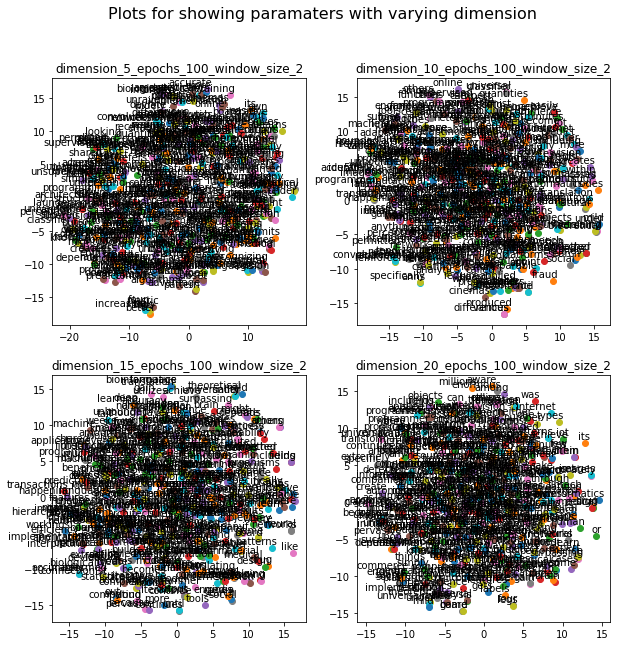

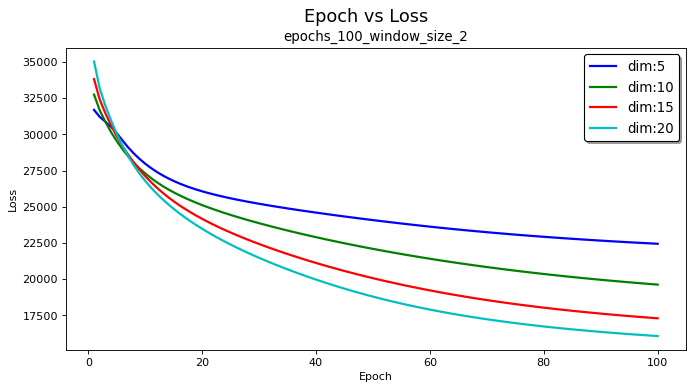

In [35]:
dimensions = [5,10,15,20]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying dimension", fontsize=16)
row=0
col=0
for dim in dimensions:
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

plt.savefig(path_to_save_scatter_plot+'varying_dim' +'.png')        
plt.show()

plot_epoch_loss('dim:',loss_epoch,'epochs_' + str(epochs) + '_window_size_' +str(window_size),path_to_save)

<h4> Varying epochs </h4>

In [37]:
window_size = 2
dimension = 20
learning_rate = 0.01

text = get_file_data() # reading data

word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)
print("length of Corpus :",length_of_corpus)
print("unique word vocab_size :",vocab_size)

length of Corpus : 1256
unique word vocab_size : 475


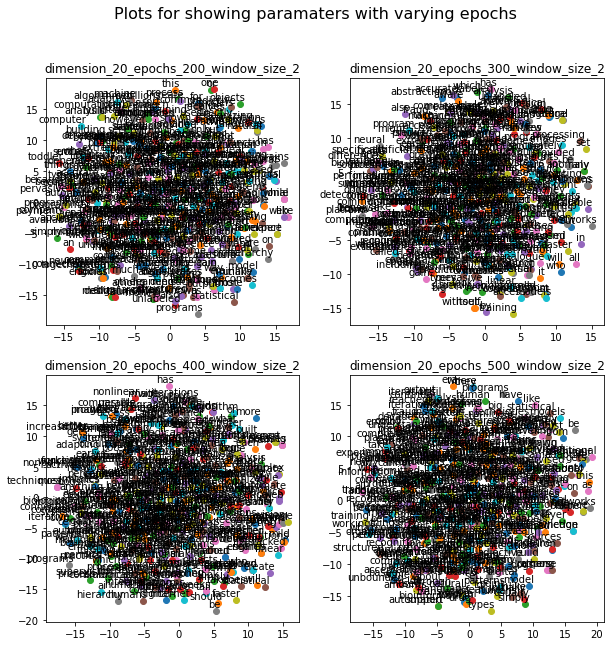

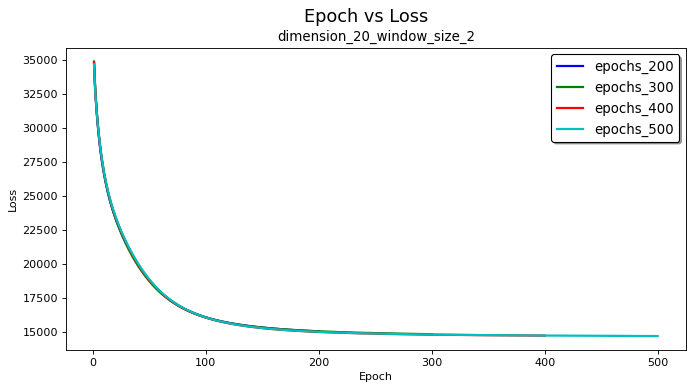

In [38]:
epochs = [200,300,400,500]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying epochs", fontsize=16)
row=0
col=0
for epoch in epochs:
    
    epoch_loss,weights_1,weights_2 = train(dimension,window_size,epoch,training_data,learning_rate)
    loss_epoch.update( {epoch: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epoch -1],
        'dimension_' + str(dimension) + '_epochs_' + str(epoch) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
plt.savefig(path_to_save_scatter_plot+'varying_epochs' +'.png')                
plt.show()
plot_epoch_loss('epochs_',loss_epoch,'dimension_' + str(dimension) + '_window_size_' +str(window_size),path_to_save)

<h4> Bigger Corpus </h4>

In [39]:
path_to_save = 'Output/epoc_loss_plot/'
path_to_save_scatter_plot = 'Output/word_similarity_scatter_plot/'

In [40]:
def word_similarity_scatter_plot_bigger_corpus(index_to_word,weight,plot_title,path):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    x = x[0:200]
    y = y[0:200]
    
    plt.figure(figsize=(20, 30)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                    family='fantasy')
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.close()   

<h4>1. Stop words effect<h4>

In [44]:
epochs = 1000
top_n_words = 5
dimension = 20
window_size = 2
learning_rate = 0.001

<h4>Without stopwords </h4>

In [45]:
text = get_file_data('yes')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)
words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)
print(words_subset)

Number of unique words: 425
Length of corpus : 801
['platforms' 'much' 'mild' 'usually' 'at']


Epoch: 0. Loss:22153.609781476112
Epoch: 50. Loss:18793.7938840828
Epoch: 100. Loss:16908.431802983374
Epoch: 150. Loss:15495.983740544674
Epoch: 200. Loss:14332.565601327478
Epoch: 250. Loss:13336.100669982528
Epoch: 300. Loss:12467.67091994175
Epoch: 350. Loss:11705.533393826234
Epoch: 400. Loss:11035.20110544016
Epoch: 450. Loss:10448.954846116098
Epoch: 500. Loss:9942.847759467097
Epoch: 550. Loss:9511.965146699053
Epoch: 600. Loss:9149.138271101925
Epoch: 650. Loss:8845.917676868692
Epoch: 700. Loss:8593.66291149017
Epoch: 750. Loss:8384.182316951843
Epoch: 800. Loss:8210.005049990812
Epoch: 850. Loss:8064.631212595307
Epoch: 900. Loss:7942.702087241323
Epoch: 950. Loss:7839.9171293150375
Epoch: 999. Loss:7754.437313041449


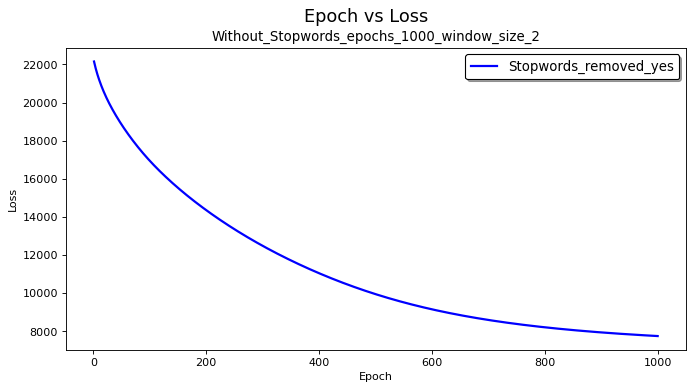

In [46]:
loss_epoch = {}
dataframe_sim = []

epoch_loss,weights_1,weights_2 = train(dimension,window_size,epochs,training_data,learning_rate,'yes',50)
loss_epoch.update( {'yes': epoch_loss} )

word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'Stopwords_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save_scatter_plot
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : Stopwords_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    words_subset
)
dataframe_sim.append(df)

plot_epoch_loss(
    'Stopwords_removed_',
    loss_epoch,
    'Without_Stopwords_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)

Similarity matrix

In [47]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('commerce', 0.74)","('unraveling', 0.6)","('online', 0.55)","('symbolic', 0.52)","('engines', 0.5)"
much,"('networks', 0.62)","('carry', 0.59)","('recurrent', 0.57)","('built', 0.57)","('identify', 0.5)"
mild,"('retaining', 0.7)","('conditions', 0.68)","('theoretical', 0.59)","('universality', 0.58)","('implementation', 0.54)"
usually,"('accurate', 0.7)","('makes', 0.54)","('four', 0.51)","('toddler', 0.5)","('faster', 0.48)"
at,"('easier', 0.73)","('simplest', 0.53)","('approach', 0.52)","('faster', 0.47)","('makes', 0.47)"


<h4> For further variations we will be removing stopwords </h4>

In [82]:
epochs = 200
top_n_words = 5
learning_rate = 0.01

In [83]:
text = get_file_data('yes')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)
words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)
print(words_subset)

Number of unique words: 425
Length of corpus : 801
['showed' 'linear' 'depends' 'bounded' 'comparable']


<h4>2. Varying dimensions of word embedding </h4>

In [48]:
window_size = 2
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

Running for dimension : 10
Epoch: 0. Loss:20770.662766301564
Epoch: 50. Loss:18812.923111594908
Epoch: 100. Loss:17615.758503807676
Epoch: 150. Loss:16638.756097522848
Epoch: 200. Loss:15818.398286166639
Epoch: 250. Loss:15125.001936186223
Epoch: 300. Loss:14512.255847168384
Epoch: 350. Loss:13954.508093879534
Epoch: 400. Loss:13443.528237973629
Epoch: 450. Loss:12974.860673659616
Epoch: 500. Loss:12543.730170433642
Epoch: 550. Loss:12146.840761222882
Epoch: 600. Loss:11782.998656199257
Epoch: 650. Loss:11451.580830487195
Epoch: 700. Loss:11151.193326883575
Epoch: 750. Loss:10879.855183113787
Epoch: 800. Loss:10635.395009133405
Epoch: 850. Loss:10415.575923003269
Epoch: 900. Loss:10218.226731347266
Epoch: 950. Loss:10041.284301419071
Epoch: 999. Loss:9885.749005919879
Running for dimension : 30
Epoch: 0. Loss:24051.707184361705
Epoch: 50. Loss:18911.40634590575
Epoch: 100. Loss:16304.059410001173
Epoch: 150. Loss:14456.527294069734
Epoch: 200. Loss:13001.512068383323
Epoch: 250. Loss:1

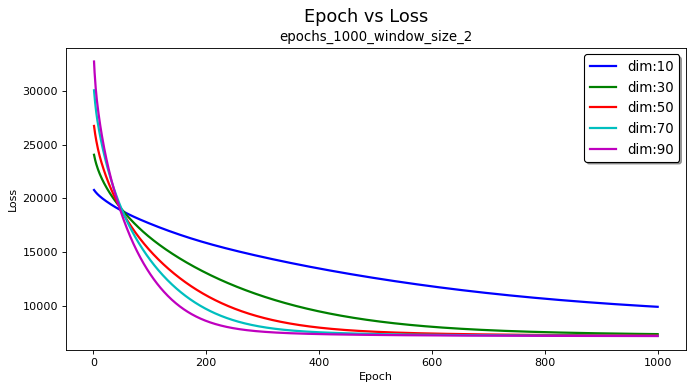

In [49]:
dimensions = [10,30,50,70,90]
loss_epoch = {}
dataframe_sim = []
for dim in dimensions:
    print('Running for dimension :' ,dim)
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate,'yes',50)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot_bigger_corpus(
        index_to_word,
        weights_1[epochs -1],
        'varying_dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        path_to_save_scatter_plot
    )
    
    df = print_similar_words(
        top_n_words,
        weights_1[epochs - 1],
        'sim_matrix for : dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        words_subset
    )
    dataframe_sim.append(df)
    
plot_epoch_loss(
    'dim:',
    loss_epoch,
    'epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)

Similarity matrix

In [50]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('online', 0.76)","('among', 0.76)","('commerce', 0.69)","('search', 0.67)","('recognition', 0.64)"
much,"('process', 0.84)","('makes', 0.84)","('faster', 0.78)","('go', 0.76)","('enables', 0.75)"
mild,"('wealth', 0.78)","('conditions', 0.78)","('analyzing', 0.73)","('collecting', 0.71)","('interpreting', 0.7)"
usually,"('faster', 0.83)","('hand', 0.72)","('recurrent', 0.7)","('makes', 0.69)","('representation', 0.69)"
at,"('easier', 0.89)","('makes', 0.88)","('simplest', 0.78)","('conditions', 0.76)","('reinforcement', 0.71)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('search', 0.56)","('online', 0.46)","('features', 0.45)","('various', 0.41)","('among', 0.4)"
much,"('makes', 0.48)","('extraction', 0.45)","('decisions', 0.45)","('drawing', 0.42)","('methods', 0.42)"
mild,"('universality', 0.51)","('case', 0.47)","('retaining', 0.47)","('conditions', 0.45)","('unraveling', 0.4)"
usually,"('recurrent', 0.53)","('architectures', 0.48)","('symbolic', 0.4)","('hand', 0.4)","('iteration', 0.4)"
at,"('simplest', 0.63)","('easier', 0.58)","('multiple', 0.46)","('conditions', 0.46)","('with', 0.44)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('engines', 0.47)","('search', 0.4)","('whence', 0.37)","('online', 0.36)","('nonlinear', 0.34)"
much,"('imagine', 0.39)","('learning', 0.36)","('possess', 0.36)","('identify', 0.35)","('the', 0.35)"
mild,"('unbounded', 0.47)","('conditions', 0.47)","('while', 0.38)","('computational', 0.37)","('incredible', 0.34)"
usually,"('enormous', 0.37)","('function', 0.36)","('easier', 0.34)","('parent', 0.32)","('subset', 0.32)"
at,"('learning', 0.37)","('functions', 0.35)","('type', 0.35)","('part', 0.35)","('organisms', 0.34)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('layer', 0.29)","('detected', 0.29)","('commerce', 0.28)","('metatags', 0.28)","('become', 0.27)"
much,"('simplest', 0.36)","('enables', 0.35)","('machines', 0.31)","('called', 0.28)","('process', 0.28)"
mild,"('universality', 0.31)","('millions', 0.3)","('shared', 0.28)","('created', 0.25)","('parent', 0.24)"
usually,"('theoretical', 0.38)","('at', 0.37)","('computer', 0.33)","('transformation', 0.33)","('unsupervised', 0.31)"
at,"('usually', 0.37)","('pattern', 0.32)","('neuron', 0.32)","('tools', 0.31)","('systems', 0.31)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('refers', 0.41)","('realize', 0.34)","('creating', 0.33)","('deviate', 0.26)","('telling', 0.25)"
much,"('linear', 0.31)","('easier', 0.3)","('telling', 0.3)","('interpreting', 0.29)","('internet', 0.28)"
mild,"('create', 0.31)","('of', 0.28)","('artificial', 0.23)","('retaining', 0.22)","('biologically', 0.21)"
usually,"('ai', 0.34)","('simplest', 0.33)","('classifier', 0.29)","('intelligence', 0.26)","('living', 0.26)"
at,"('applies', 0.26)","('months', 0.25)","('makes', 0.24)","('iot', 0.23)","('processing', 0.23)"


<h4>3. Varying window size </h4>

In [51]:
epochs = 200
top_n_words = 5
learning_rate = 0.01
dimension = 70

Running for window_size : 5
Epoch: 0. Loss:68200.75234413228
Epoch: 50. Loss:25238.496611440132
Epoch: 100. Loss:24990.416144535277
Epoch: 150. Loss:24912.178865887818
Epoch: 199. Loss:24864.22821642777
Running for window_size : 7
Epoch: 0. Loss:92368.34754860212
Epoch: 50. Loss:37604.59466421556
Epoch: 100. Loss:37281.79065800716
Epoch: 150. Loss:37174.12094280371
Epoch: 199. Loss:37113.14620018866
Running for window_size : 9
Epoch: 0. Loss:115077.25858381695
Epoch: 50. Loss:50333.16122664916
Epoch: 100. Loss:49929.1162365126
Epoch: 150. Loss:49790.36667351173
Epoch: 199. Loss:49717.99702629823
Running for window_size : 11
Epoch: 0. Loss:137597.10974713773
Epoch: 50. Loss:62916.315193614275
Epoch: 100. Loss:62396.17478035827
Epoch: 150. Loss:62220.56056530085
Epoch: 199. Loss:62130.14096029132


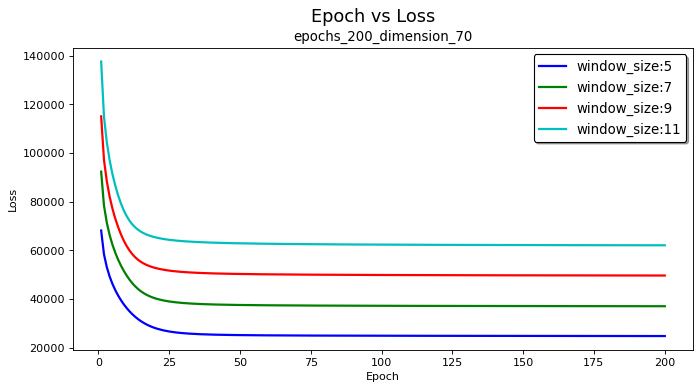

In [52]:
window_size = [5,7,9,11]
loss_epoch = {}
dataframe_sim = []
for ws in window_size:
    print('Running for window_size :' ,ws)
    
    training_data,training_sample_words = generate_training_data(corpus,ws,vocab_size,word_to_index,length_of_corpus)
    
    epoch_loss,weights_1,weights_2 = train(dimension,ws,epochs,training_data,learning_rate,'yes',50)
    loss_epoch.update( {ws: epoch_loss} )
    
    word_similarity_scatter_plot_bigger_corpus(
        index_to_word,
        weights_1[epochs -1],
        'varuing_window_size_' + str(ws) + '_epochs_' + str(epochs) + 'dimension_' +str(dimension),
        path_to_save_scatter_plot
    )
    
    df = print_similar_words(
        top_n_words,
        weights_1[epochs - 1],
        'sim_matrix for : dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(ws),
        words_subset
    )
    dataframe_sim.append(df)
    
plot_epoch_loss(
    'window_size:',
    loss_epoch,
    'epochs_' + str(epochs) + '_dimension_' +str(dimension),
    path_to_save
)

Similarity matrix

In [53]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('online', 0.45)","('cinemas', 0.38)","('engines', 0.37)","('social', 0.35)","('media', 0.32)"
much,"('go', 0.48)","('algorithm', 0.36)","('identify', 0.36)","('acceptable', 0.34)","('languages', 0.33)"
mild,"('conditions', 0.62)","('universality', 0.54)","('theoretical', 0.48)","('retaining', 0.44)","('application', 0.4)"
usually,"('initially', 0.5)","('accurate', 0.48)","('supervision', 0.42)","('learn', 0.39)","('faster', 0.39)"
at,"('simplest', 0.59)","('easier', 0.51)","('makes', 0.5)","('faster', 0.41)","('learning', 0.4)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('commerce', 0.67)","('search', 0.56)","('cinemas', 0.55)","('among', 0.49)","('online', 0.48)"
much,"('go', 0.59)","('each', 0.55)","('identify', 0.55)","('applies', 0.5)","('hierarchy', 0.45)"
mild,"('conditions', 0.68)","('in', 0.56)","('retaining', 0.55)","('universality', 0.54)","('implementation', 0.51)"
usually,"('initially', 0.63)","('faster', 0.49)","('supervision', 0.49)","('unsupervised', 0.49)","('accurate', 0.48)"
at,"('thought', 0.64)","('simplest', 0.53)","('analytics', 0.52)","('easier', 0.47)","('faster', 0.47)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('engines', 0.64)","('commerce', 0.62)","('online', 0.62)","('search', 0.56)","('others', 0.56)"
much,"('go', 0.65)","('identify', 0.6)","('each', 0.56)","('preceding', 0.53)","('hierarchy', 0.52)"
mild,"('conditions', 0.65)","('universality', 0.64)","('implementation', 0.62)","('retaining', 0.58)","('optimized', 0.58)"
usually,"('initially', 0.64)","('provided', 0.64)","('accurate', 0.61)","('faster', 0.59)","('builds', 0.58)"
at,"('easier', 0.7)","('simplest', 0.66)","('thought', 0.63)","('automate', 0.57)","('makes', 0.55)"


,similar:1,similar:2,similar:3,similar:4,similar:5
platforms,"('online', 0.73)","('others', 0.68)","('commerce', 0.61)","('media', 0.61)","('amount', 0.6)"
much,"('go', 0.77)","('identify', 0.67)","('each', 0.6)","('gained', 0.57)","('applies', 0.56)"
mild,"('conditions', 0.71)","('universality', 0.7)","('theoretical', 0.67)","('retaining', 0.61)","('heterogeneous', 0.6)"
usually,"('initially', 0.68)","('provided', 0.63)","('accurate', 0.55)","('supervision', 0.54)","('program', 0.54)"
at,"('simplest', 0.74)","('makes', 0.66)","('easier', 0.66)","('thought', 0.64)","('analytics', 0.61)"


<h4> Final training with dimension = 70 , window_size = 2 , epochs = 1000 </h4>

In [46]:
print(words_subset)
window_size = 2
dimension = 70
epochs = 1000

['informs' 'seeing' 'control' 'berlin' 'commits']


In [47]:
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

Epoch: 0. Loss:46652.027071939316
Epoch: 200. Loss:9443.945373451474
Epoch: 400. Loss:9375.996833937867
Epoch: 600. Loss:9329.683420409203
Epoch: 800. Loss:9295.01018810291
Epoch: 999. Loss:9268.063023148969


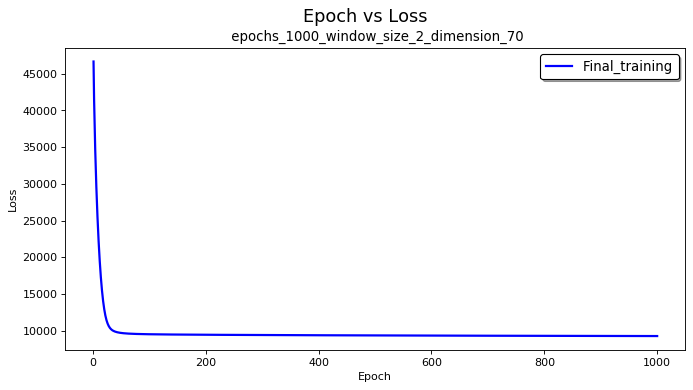

In [48]:
loss_epoch = {}
dataframe_sim = []
    
epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate,'yes',200)
loss_epoch.update( {'': epoch_loss} )

word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    'final_training_scatter_plot_'
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    words_subset
)
dataframe_sim.append(df)

plot_epoch_loss(
    'Final_training',
    loss_epoch,
    ' epochs_' + str(epochs) + '_window_size_' +str(window_size) + '_dimension_' +str(dimension),
    'final_training_epoch_loss_plot_'
)

In [49]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

,similar:1,similar:2,similar:3,similar:4,similar:5
informs,"('sector', 0.27)","('angelo', 0.27)","('act', 0.27)","('everyone', 0.26)","('british', 0.25)"
seeing,"('twists', 0.28)","('suddenly', 0.27)","('hour', 0.26)","('if', 0.26)","('even', 0.25)"
control,"('archer', 0.29)","('daring', 0.27)","('contact', 0.25)","('actions', 0.25)","('changes', 0.23)"
berlin,"('politics', 0.35)","('note', 0.29)","('day', 0.27)","('war', 0.25)","('nick', 0.25)"
commits,"('seeks', 0.32)","('anatoly', 0.27)","('sloane', 0.25)","('book', 0.24)","('behind', 0.24)"
